In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import joblib

from tensorflow import keras
from tensorflow.keras import layers

import xgboost as xgb

In [122]:
s_file = up.open("signal_tutorial.root")
b_file = up.open("background_tutorial.root")

s_tree = s_file['tree']
b_tree = b_file['tree']


In [123]:
b_tree.keys()

['index',
 'bjet1_pt_NOSYS',
 'bjet2_pt_NOSYS',
 'lepton_pt_NOSYS',
 'weight_total_NOSYS']

In [124]:
branch_names = ['bjet1_pt_NOSYS','bjet2_pt_NOSYS', 'lepton_pt_NOSYS']

s_arrays = s_tree.arrays(branch_names, library="pd")
b_arrays = b_tree.arrays(branch_names, library="pd")


df_s = pd.DataFrame(s_arrays)
df_b = pd.DataFrame(b_arrays)

In [125]:
df_s

,bjet1_pt_NOSYS,bjet2_pt_NOSYS,lepton_pt_NOSYS
0,209.781594,42.806797,34.276246
1,232.191156,69.051812,70.892523
2,172.081141,127.746648,76.198148
3,76.555508,70.607641,124.767469
4,213.016969,143.993281,79.400477
...,...,...,...
195,103.375914,25.456709,39.901324
196,71.821289,34.451637,154.938234
197,83.824187,66.607797,198.940281
198,143.771312,131.378906,93.547656


In [126]:
df_s['Class'] = 1
df_b['Class'] = 0

print("Total Signal events: ",len(df_s))
print("Total Bkg events: ",len(df_b))

Total Signal events:  200
Total Bkg events:  500


In [127]:
df = pd.concat([df_s, df_b]).reset_index(drop=True).sample(frac=1)
y_df = df.pop('Class')

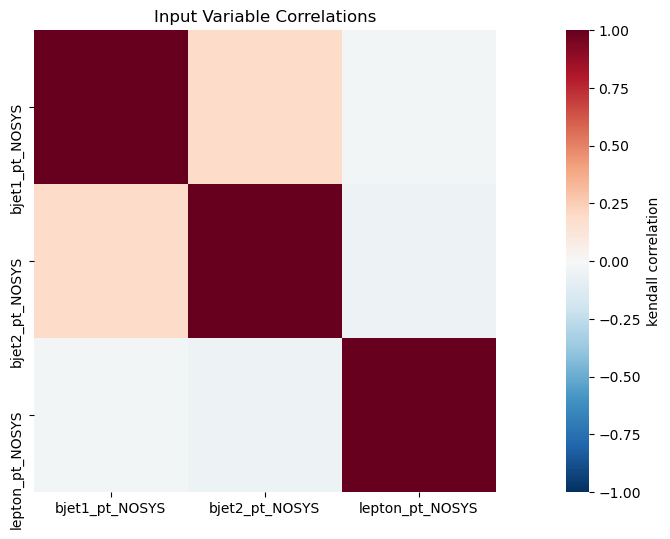

In [128]:
method = 'kendall'
correlations = df_s[branch_names].astype(np.float64).corr(method = method) # Kendall correlation coefficient ...
plt.figure(figsize = (18,6))
sns.heatmap(correlations, vmin = -1, annot = False, square = True, cbar_kws = {'label' : method+' correlation'}, cmap="RdBu_r")
plt.title('Input Variable Correlations')
plt.show()

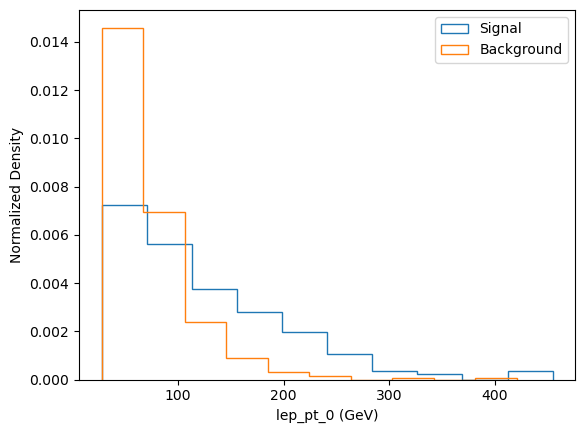

In [129]:
signal_data = df_s['lepton_pt_NOSYS'] 
background_data = df_b['lepton_pt_NOSYS'] 

plt.hist(signal_data,  label='Signal', density=True, histtype='step')
plt.hist(background_data, label='Background', density=True, histtype='step')

plt.xlabel('lep_pt_0 (GeV)')
plt.ylabel('Normalized Density')
plt.legend()

plt.show()


In [130]:
X_train_1,X_test_1,y_train,y_test = train_test_split(df[branch_names],y_df,test_size=0.2,random_state=0)

In [131]:
# Preprocessing
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_1)
X_test = scaler.transform(X_test_1)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

In [132]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.6896551724137931, 1: 1.8181818181818181}


In [133]:
#Define the neural network model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

#Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Precision'])

#Train the model
history = model.fit(
    X_train_np, y_train_np, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.2, class_weight=class_weight_dict
)


/lustre/work/client/users/santoshp/.conda/envs/sklearn/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - Precision: 0.3835 - accuracy: 0.5932 - loss: 0.6910 - val_Precision: 0.4400 - val_accuracy: 0.7411 - val_loss: 0.6444
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.5303 - accuracy: 0.7323 - loss: 0.6026 - val_Precision: 0.4565 - val_accuracy: 0.7589 - val_loss: 0.6114
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.5884 - accuracy: 0.7760 - loss: 0.5572 - val_Precision: 0.5000 - val_accuracy: 0.7946 - val_loss: 0.5829
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6229 - accuracy: 0.8031 - loss: 0.4965 - val_Precision: 0.5000 - val_accuracy: 0.7946 - val_loss: 0.5432
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6062 - accuracy: 0.7918 - loss: 0.4709 - val_Precision: 0.5000 - val_accuracy: 0.7946 - val_loss: 0.4993
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.6472 - accuracy: 0.8255 - loss: 0.4295 - val_Precision: 0.5278 - val_accuracy: 0.812

In [134]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Calculate accuracy and precision
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)

print("Accuracy: ", accuracy)
print("Precision: ", precision)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Accuracy:  0.7785714285714286
Precision:  0.631578947368421


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


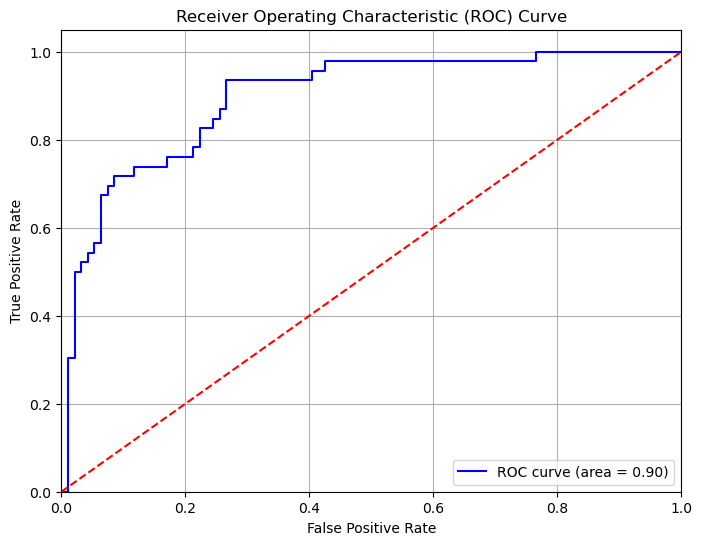

In [135]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_pred_probs = model.predict(X_test).ravel()  # Flatten the array

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line (no discrimination)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


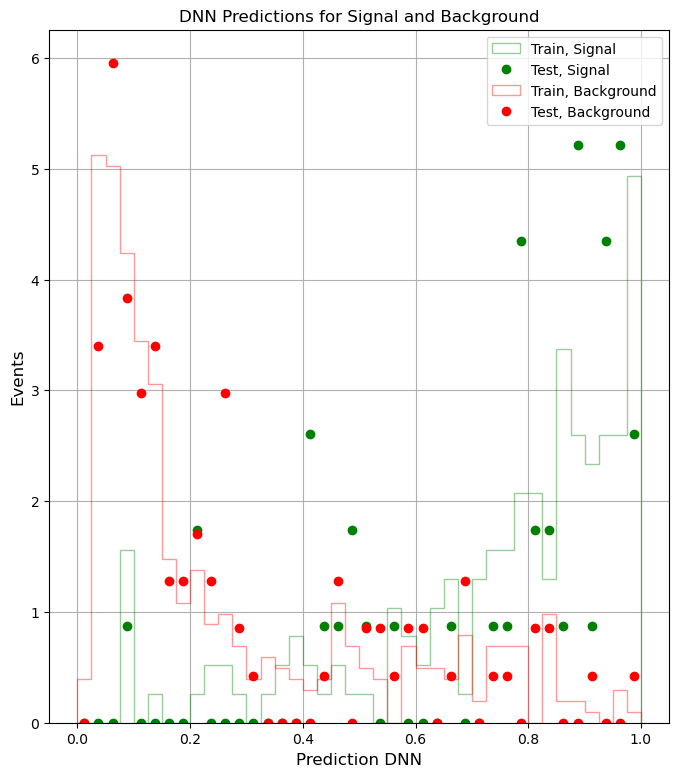

In [136]:
y_pred_signal_train = model.predict(X_train[y_train == 1])  # Predictions for training set, Signal
y_pred_signal_test = model.predict(X_test[y_test == 1])     # Predictions for test set, Signal
y_pred_background_train = model.predict(X_train[y_train == 0])  # Predictions for training set, Background
y_pred_background_test = model.predict(X_test[y_test == 0])     # Predictions for test set, Background


n_bins = 40
hist_range = (0, 1.0)
plt.figure(figsize=(8, 9))


plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")


plt.xlabel("Prediction DNN", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.grid()
plt.title("DNN Predictions for Signal and Background")
plt.show()


In [ ]:
##########Validate###############

In [ ]:
########Evaluation Part#################### 

In [139]:
val_s_file = up.open("signal_tutorial.root")
val_b_file = up.open("background_tutorial.root")
#val_d_file = up.open("/users/santoshp/BCVSPIN_Masterclass/BCVSPIN_Data/val_set/data.root")

v_s_tree = val_s_file['tree']
v_b_tree = val_b_file['tree']
#v_d_tree = val_d_file['tree']

branch_names = ['bjet1_pt_NOSYS','bjet2_pt_NOSYS', 'lepton_pt_NOSYS']

total_branch = branch_names + ['weight_total_NOSYS']

v_s_arrays = v_s_tree.arrays(branch_names, library="pd")
v_s_arrays_t = v_s_tree.arrays(total_branch, library="pd")

v_b_arrays = v_b_tree.arrays(branch_names, library="pd")
v_b_arrays_t = v_b_tree.arrays(total_branch, library="pd")

#v_d_arrays = v_d_tree.arrays(branch_names, library="pd")
#v_d_arrays_t = v_d_tree.arrays(total_branch, library="pd")


v_df_s = pd.DataFrame(v_s_arrays)
v_df_s_t = pd.DataFrame(v_s_arrays_t)

v_df_b = pd.DataFrame(v_b_arrays)
v_df_b_t = pd.DataFrame(v_b_arrays_t)

#v_df_d = pd.DataFrame(v_d_arrays)
#v_df_d_t = pd.DataFrame(v_d_arrays_t)

In [140]:
print("Total Signal events: ",len(v_df_s))
print("Total Bkg events: ",len(v_df_b))
#print("Total Data events: ",len(v_df_d))

Total Signal events:  200
Total Bkg events:  500


In [141]:
y_s_1 = scaler.transform(v_df_s)
y_b_1 = scaler.transform(v_df_b)
#y_d_1 = scaler.transform(v_df_d)

y_s = model.predict(y_s_1)
y_b = model.predict(y_b_1)
#y_d = model.predict(y_d_1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


In [142]:
v_df_s_t['DNN_score'] = y_s
v_df_b_t['DNN_score'] = y_b
#v_df_d_t['DNN_score'] = y_d

In [ ]:
################stack plot#########

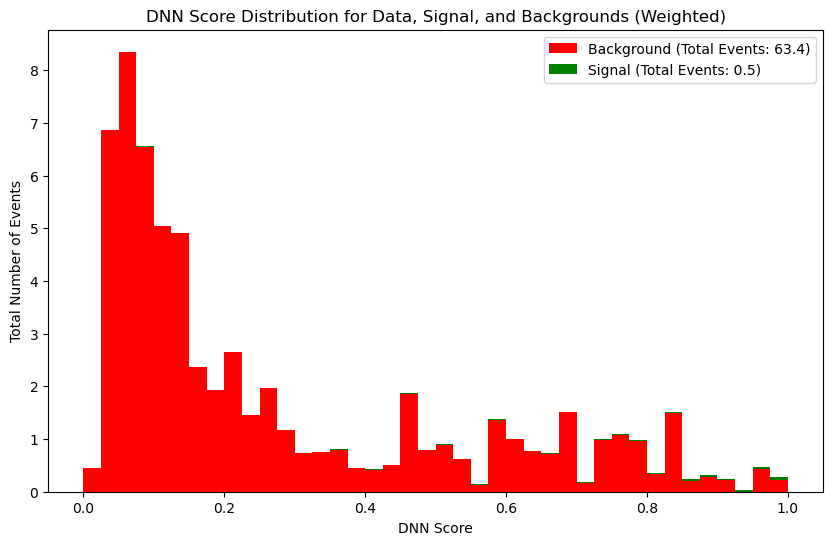

In [147]:
data_to_plot = [v_df_b_t['DNN_score'], v_df_s_t['DNN_score']]
weights_to_use = [v_df_b_t['weight_total_NOSYS'], v_df_s_t['weight_total_NOSYS']]

# Calculate event totals
total_signal = np.sum(v_df_s_t['weight_total_NOSYS'])
total_background = np.sum(v_df_b_t['weight_total_NOSYS'])
#total_data = len(v_df_d_t)

# Stacked histogram for signal and background
plt.figure(figsize=(10, 6))
plt.hist(data_to_plot, bins=40, range=(0, 1), weights=weights_to_use, stacked=True, 
         label=[f'Background (Total Events: {total_background:.1f})', 
                f'Signal (Total Events: {total_signal:.1f})'],
         color=['red', 'green'])

# Calculate bin centers for data
bins = np.linspace(0, 1, 41)
bin_centers = 0.5 * (bins[1:] + bins[:-1])

# Data histogram and errors
#data_hist, _ = np.histogram(v_df_d_t['bdt_score'], bins=bins)
#data_errors = np.sqrt(data_hist)


#plt.errorbar(bin_centers, data_hist, fmt='o', yerr=data_errors,
#             label=f'Data (Total Events: {total_data})', color='black', 
#             markersize=5, capsize=3)

plt.title('DNN Score Distribution for Data, Signal, and Backgrounds (Weighted)')
plt.xlabel('DNN Score')
plt.ylabel('Total Number of Events')
# plt.yscale('log') 

plt.legend()
plt.show()

In [ ]:
#Calculate Signigicance

In [152]:
# Define bins as before
bins = np.linspace(0, 1, 41)  # 20 bins from 0 to 1 (or adjust as needed)

# Calculate histograms for signal and background individually
signal_hist, _ = np.histogram(v_df_s_t['DNN_score'], bins=bins, weights=v_df_s_t['weight_total_NOSYS'])
background_hist, _ = np.histogram(v_df_b_t['DNN_score'], bins=bins, weights=v_df_b_t['weight_total_NOSYS'])

# Calculate the histogram for data as well
#data_hist, _ = np.histogram(v_df_d_t['DNN_score'], bins=bins)

# Sum the counts in the last two bins for each histogram
# The last two bins are at indices -2 and -1
signal_last_two = signal_hist[-2:].sum()
background_last_two = background_hist[-1:].sum()
#data_last_two = data_hist[-2:].sum()

# Print the values
#print(f"Last two bins:\nSignal: {signal_last_two:.3f}\nBackground: {background_last_two:.3f}\nData: {data_last_two:.3f}")
print(f"Last two bins:\nSignal: {signal_last_two:.3f}\nBackground: {background_last_two:.3f}")



Last two bins:
Signal: 0.095
Background: 0.231


In [153]:
# Calculate the significance in the last two bins
N_sig_last_two = signal_last_two
N_bg_last_two = background_last_two

# Apply the signal significance formula (adjust uncertainty model as needed)
signal_significance_last_two = N_sig_last_two / np.sqrt(N_bg_last_two + 0.3 * N_bg_last_two**2)
print(f"Signal Significance in Last Two Bins: {signal_significance_last_two:.3f}")


Signal Significance in Last Two Bins: 0.192


In [155]:
# # Define observed signal as the excess of data over background
# N_sig_observed_last_two = max(data_last_two - background_last_two, 0)  # Clip to avoid negative signal
# N_bg_last_two = background_last_two  # Background remains the same

# # Calculate observed significance
# observed_significance_last_two = N_sig_observed_last_two / np.sqrt(N_bg_last_two + 0.3 * N_bg_last_two**2)

# print(f"Observed Significance in Last Two Bins: {observed_significance_last_two:.3f}")


# Train with BDT?

In [157]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [158]:
clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')

Accuracy: 0.8285714285714286
Precision: 0.7391304347826086


In [159]:
y_s = clf.predict_proba(v_df_s)

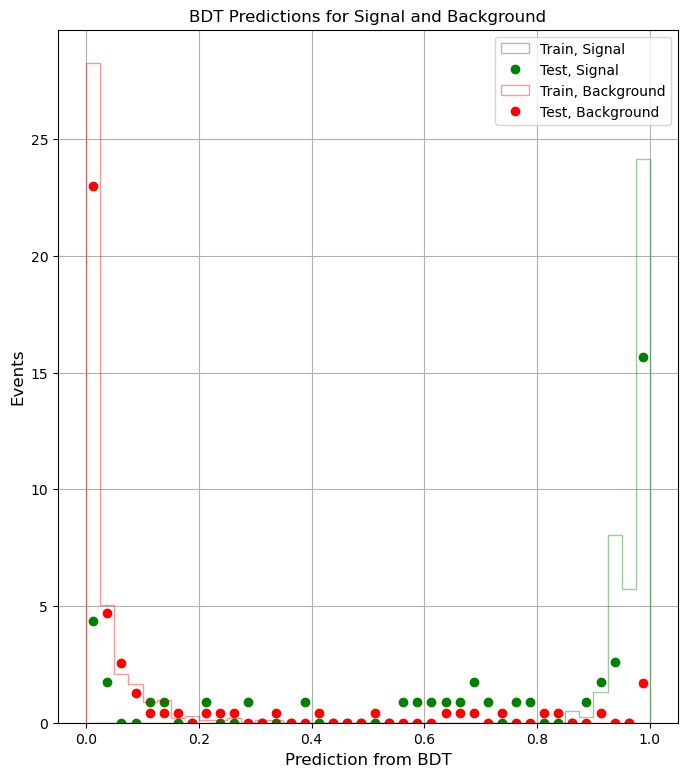

In [162]:
y_pred_signal_train = clf.predict_proba(X_train[y_train == 1])[:, 1]  # Predictions for training set, Signal
y_pred_signal_test = clf.predict_proba(X_test[y_test == 1])[:, 1]     # Predictions for test set, Signal
y_pred_background_train = clf.predict_proba(X_train[y_train == 0])[:, 1]  # Predictions for training set, Background
y_pred_background_test = clf.predict_proba(X_test[y_test == 0])[:, 1]     # Predictions for test set, Background

n_bins = 40
hist_range = (0, 1.0)
plt.figure(figsize=(8, 9))

plt.hist(y_pred_signal_train, bins=n_bins, range=hist_range, histtype='step', color="green", density=True, alpha=0.4, label="Train, Signal")
counts, bin_edges = np.histogram(y_pred_signal_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="green", label="Test, Signal")

plt.hist(y_pred_background_train, bins=n_bins, range=hist_range, histtype='step', density=True, alpha=0.4, color="red", label="Train, Background")
counts, bin_edges = np.histogram(y_pred_background_test, bins=n_bins, range=hist_range, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
plt.plot(bin_centers, counts, marker="o", linestyle="None", color="red", label="Test, Background")

plt.xlabel("Prediction from BDT", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.legend()
plt.grid()
plt.title("BDT Predictions for Signal and Background")
plt.show()


# Follow similar approcah as DNN